In [1]:
"""
The spatial attack is a very special attack because it tries to find adversarial
perturbations using a set of translations and rotations rather then in an Lp ball.
It therefore has a slightly different interface.
"""
import os
import torchvision.models as models
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
import foolbox.attacks as fa
from autoattack import AutoAttack
import torch
import foolbox as fb
from pathlib import Path

In [2]:
home = str(Path.home())
base_path = os.path.join(home, 'workspace/multiLID/data/gen/run_1/')

In [3]:
model = models.wide_resnet50_2(pretrained=True).eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)

/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
adversary = AutoAttack(fmodel, norm='Linf', eps=8/255., log_path=None,  verbose=True, version='standard')

adversary.seed = 0

setting parameters for standard version


In [6]:
# get data and test the model
# wrapping the tensors with ep.astensors is optional, but it allows
# us to work with EagerPy tensors in the following
(images, labels), restore_type = ep.astensors_(*samples(fmodel, dataset="imagenet", batchsize=16))
clean_acc = accuracy(fmodel, images, labels) * 100
print(f"clean accuracy:  {clean_acc:.1f} %")

clean accuracy:  93.8 %


In [9]:
x_adv = adversary.run_standard_evaluation(restore_type(images), restore_type(labels), bs=16)

using standard version including apgd-ce, apgd-t, fab-t, square
initial accuracy: 93.75%
apgd-ce - 1/1 - 15 out of 15 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 15.4 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%


In [11]:
x_adv.shape

torch.Size([16, 3, 224, 224])

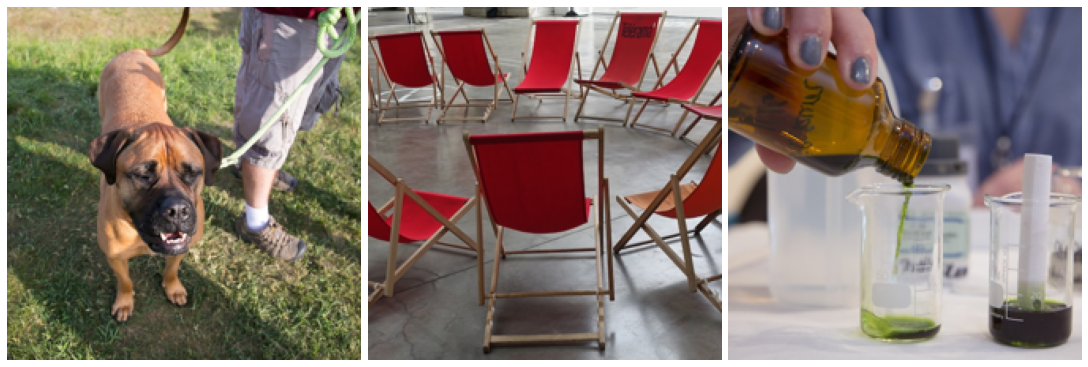

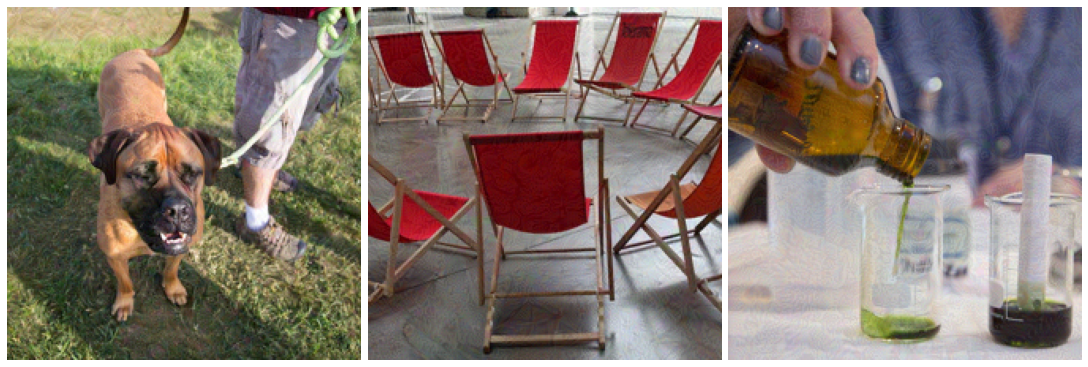

In [13]:
fb.plot.images(images, n=3, scale=5)
fb.plot.images(x_adv, n=3, scale=5)

In [21]:
labels

PyTorchTensor(tensor([243, 559, 438, 990, 949, 853, 609, 609, 915, 455, 541, 630, 741, 471,
                      129,  99], device='cuda:0'))

In [24]:
images.shape

torch.Size([16, 3, 224, 224])

In [30]:
torch.max(restore_type(fmodel(images)), dim=1)[1] == labels

PyTorchTensor(tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
                       True,  True,  True,  True,  True,  True], device='cuda:0'))

In [32]:
torch.max(restore_type(fmodel(images)), dim=1)[1]

tensor([243, 559, 438, 990, 949, 853, 609, 511, 915, 455, 541, 630, 741, 471,
        129,  99], device='cuda:0')

In [31]:
torch.max(fmodel(x_adv), dim=1)[1] == labels

PyTorchTensor(tensor([False, False, False, False, False, False, False, False, False, False,
                      False, False, False, False, False, False], device='cuda:0'))

In [34]:
torch.max(fmodel(x_adv), dim=1)[1]

tensor([242, 765, 440, 752, 957, 706, 751, 511, 663, 721, 542, 752, 497, 428,
         85,  85], device='cuda:0')